In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import operator
import statistics

In [5]:
from flask import Flask,jsonify

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

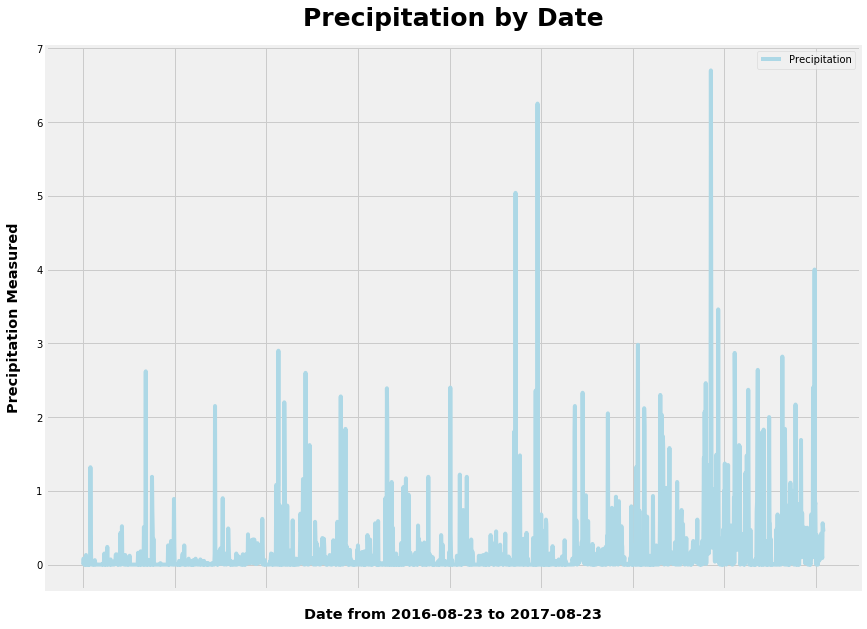

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
resultproxy_all = session.execute( "SELECT * FROM measurement")
climateList = [{column: value for column, value in rowproxy.items()} for rowproxy in resultproxy_all]

# Calculate the date 1 year ago from the last data point in the database
endpt = climateList[-1]
endYear = dt.datetime.strptime( endpt['date'], "%Y-%m-%d").date()
prevYear = endYear.replace( endYear.year - 1 )

# Perform a query to retrieve the data and precipitation scores
queryPrecip = session.query( Measurement.date, Measurement.prcp ).\
        filter( Measurement.date <= endYear).\
        filter( Measurement.date >= prevYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
date_prec_df = pd.DataFrame( queryPrecip, columns=['Date', 'Precipitation'] )
date_prec_df = date_prec_df.set_index('Date')

# Light clean up of data
date_prec_df = date_prec_df.dropna()
date_prec_df = date_prec_df.replace( 0, 0.0 )

# Use Pandas Plotting with Matplotlib to plot the data
date_prec_df.plot( color='lightblue', figsize=(13,10))

# Labeling
plt.title( s="Precipitation by Date", pad=20,
              fontdict={'fontweight': 'bold', 'fontsize': 25} )
plt.xlabel( f"Date from {prevYear} to {endYear}", labelpad=15, fontweight='bold', fontsize='x-large' )
plt.ylabel( "Precipitation Measured", labelpad=15, fontweight='bold', fontsize='x-large' )

# Save figure
plt.savefig( 'Prec_v_Date.png', bbox='tight')

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = {}
stats["Count"] = date_prec_df['Precipitation'].count()
stats["Sum"] = date_prec_df['Precipitation'].sum()
stats["Average"] = date_prec_df['Precipitation'].mean()
stats["Median"] = date_prec_df['Precipitation'].median()
stats["Mode"] = date_prec_df['Precipitation'].mode()
stats["Standard Deviation"] = date_prec_df['Precipitation'].std()
stats["Lowest Value"] = date_prec_df['Precipitation'].min()
stats["Highest Value"] = date_prec_df['Precipitation'].max()
stats

{'Count': 2021,
 'Sum': 358.28000000000003,
 'Average': 0.17727857496288996,
 'Median': 0.02,
 'Mode': 0    0.0
 dtype: float64,
 'Standard Deviation': 0.4611895038877028,
 'Lowest Value': 0.0,
 'Highest Value': 6.7}

In [14]:
# Design a query to show how many stations are available in this dataset?
numStations = session.query( Measurement.station ).distinct().count()
numStations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
stations = session.query( Measurement.station ).distinct().all()

# List the stations and the counts in descending order
statList = []
for stat in stations:
    count = session.query( Measurement.station ).filter( Measurement.station == stat[0] ).count()
    statList.append( (stat[0], count) )
    
statList.sort(key=operator.itemgetter(1),reverse=True)
statList

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Station with highest observations
top = statList[0][0]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station
low = session.query( func.min(Measurement.tobs) ).filter( Measurement.station == top ).all()[0][0]
high = session.query( func.max(Measurement.tobs) ).filter( Measurement.station == top ).all()[0][0]
avg = session.query( func.avg(Measurement.tobs) ).filter( Measurement.station == top ).all()[0][0]

# Format average
avg = round(avg*10)/10

# Display stats for most active station
print( "Lowest Temp: ", low,
      "\nHighest Temp: ", high,
      "\nAverage Temp: ", avg )

Lowest Temp:  54.0 
Highest Temp:  85.0 
Average Temp:  71.7


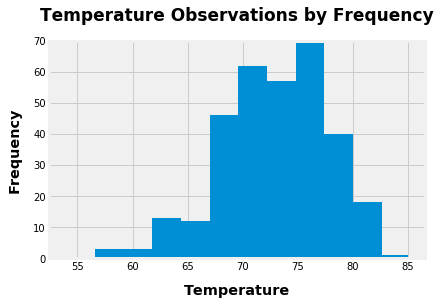

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
queryTemps = session.query( Measurement.tobs ).\
        filter( Measurement.station == top ).\
        filter( Measurement.date <= endYear ).\
        filter( Measurement.date >= prevYear ).all()
queryTemps = [ temp[0] for temp in queryTemps ]

# Plot the results as a histogram
bins = [54, 56.6, 59.2, 61.8, 64.4, 67, 69.6, 72.2, 74.8, 77.4, 80, 82.6, 85]
plt.ylim(0,70)
plt.hist(queryTemps, bins=bins)

# Label axes
plt.title('Temperature Observations by Frequency', pad=20,
              fontdict={'fontweight': 'bold', 'fontsize': 17})
plt.xlabel('Temperature', labelpad=12, fontweight='bold', fontsize='x-large')
plt.ylabel('Frequency', labelpad=12, fontweight='bold', fontsize='x-large')

# Save figure
plt.savefig( 'Temp_Freq.png', bbox='tight')

## Temperature Analysis (Optional)

The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.

Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Step 2 - Climate App

#### Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.
Use FLASK to create your routes.

In [23]:
# Flask Setup
app = Flask(__name__)

In [24]:
# Home page.
# List all routes that are available.
@app.route("/")
def welcome():
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [25]:
# Convert the query results to a Dictionary using date as the key and prcp as the value.
# Return the JSON representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation():
    resultsDict = {}
    results = session.query( Measurement.date, Measurement.prcp )
    for pair in results:
        resultsDict[pair[0]] = pair[1]

    return jsonify(results)

In [26]:
# Return a JSON list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stations():
    results = session.query( Measurement.station ).distinct().all()

    return jsonify(all_passengers)

In [27]:
# Query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.
@app.route("/api/v1.0/tobs")
def temps():
    results = session.query( Measurement.date, Measurement.tobs ).\
        filter( Measurement.date <= endYear).\
        filter( Measurement.date >= prevYear)[1].all()
    
    return jsonify(results)

In [29]:
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.
@app.route( "/api/v1.0/<start>/", defaults={'end': None} )
@app.route( "/api/v1.0/<start>/<end>" )
def tempStats( start,end ):
    results = []
    if end != None:
        results = session.query( Measurement.date, Measurement.tobs ).\
        filter( Measurement.date <= end).\
        filter( Measurement.date >= start)
    else:
        results =  session.query( Measurement.date, Measurement.tobs ).\
        filter( Measurement.date >= start)
    return jsonify(results)

if __name__ == '__main__':
    app.run(debug=True)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
